In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import zipfile


In [ ]:
# Define paths for the zip file and its extraction location
#zip_path = '/content/faces_224.zip'  # Path to the uploaded zip file
unzip_path = '/content'   # Path where files will be unzipped
zip_path = '/content/faces_224.zip'

import zipfile
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Update the image path
image_path = unzip_path

In [ ]:
def create_efficient_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False  # Freeze the base model initially

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
def create_light_augmentation():
    return ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],   # Added brightness adjustment
        zoom_range=0.2,                # Added zoom
        preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
    )


In [ ]:
def train_efficient_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs=50):
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    ]

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_generator, validation_steps=validation_steps,
                        callbacks=callbacks)

    return history

In [ ]:
def fine_tune_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs=10):
    base_model = model.layers[0]  # Get the base model (MobileNetV3Small)
    base_model.trainable = True   # Unfreeze the base model for fine-tuning

    # Freeze all layers except the last few (fine-tune only these layers)
    for layer in base_model.layers[:-10]:  # Adjust the number of layers as needed
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_generator, validation_steps=validation_steps,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

    return history

In [ ]:
def retrieve_generator(set_name, image_path, target_size=(224, 224), batch_size=32):
    indices = np.arange(len(set_name))
    while True:
        np.random.shuffle(indices)  # Shuffle indices each epoch
        for start in range(0, len(set_name), batch_size):
            images, labels = [], []
            end = min(start + batch_size, len(set_name))
            batch_indices = indices[start:end]
            batch_set = set_name.iloc[batch_indices]

            for img, imclass in zip(batch_set['videoname'], batch_set['label']):
                img_path = os.path.join(image_path, img[:-4] + '.jpg')
                image = cv2.imread(img_path)

                if image is not None:
                    image = cv2.resize(image, target_size)
                    images.append(image)
                    labels.append(1 if imclass == 'FAKE' else 0)
                else:
                    print(f"Warning: Image not found or cannot be read - {img_path}")

            yield np.array(images), np.array(labels)



Loading metadata...
Metadata loaded.
Splitting dataset...
Dataset split complete.
Creating model...
Training model...
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5880 - loss: 0.7308 - val_accuracy: 0.6606 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.6963 - loss: 0.5771 - val_accuracy: 0.6865 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.7341 - loss: 0.5273 - val_accuracy: 0.7060 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7503 - loss: 0.5010 - val_accuracy: 0.7017 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7784 - loss: 0.4637 - val_accuracy: 0.7115 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7875 - loss: 0.4491 - val_accuracy: 0.7108 -

Final Test Accuracy: 0.7573


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

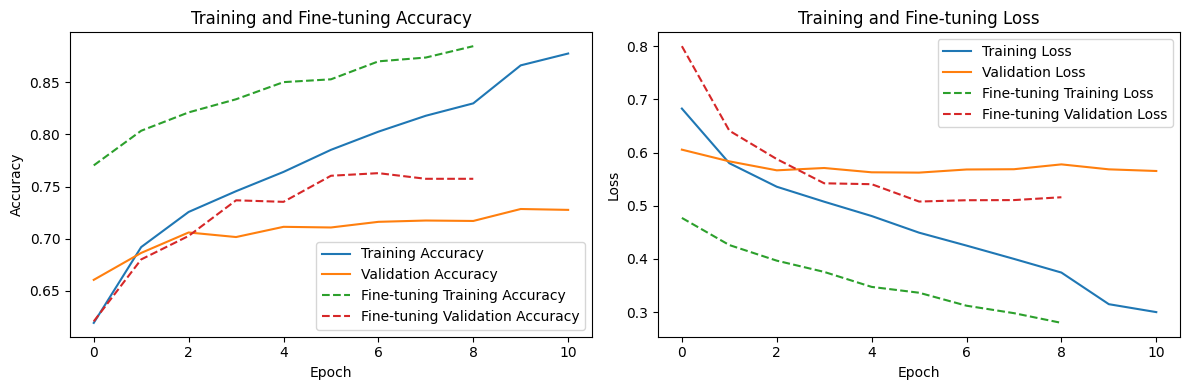

In [ ]:
# Main execution
if __name__ == "__main__":
    # Define dataset paths (using your existing paths)
    metadata_path = r"/content/metadata.csv"
    image_path = r"/content/faces_224"

    # Load metadata
    print("Loading metadata...")
    df = pd.read_csv(metadata_path)
    print("Metadata loaded.")

    # Sample and split data
    print("Splitting dataset...")
    real_df = df[df["label"] == "REAL"]
    fake_df = df[df["label"] == "FAKE"]
    sample_size = 10000
    real_df = real_df.sample(sample_size, random_state=42)
    fake_df = fake_df.sample(sample_size, random_state=42)
    sample_meta = pd.concat([real_df, fake_df])

    Train_set, Test_set = train_test_split(sample_meta, test_size=0.2, random_state=42, stratify=sample_meta['label'])
    Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])
    print("Dataset split complete.")

    # Initialize generators
    batch_size = 32
    train_generator = retrieve_generator(Train_set, image_path=image_path, batch_size=batch_size )
    val_generator = retrieve_generator(Val_set, image_path=image_path, batch_size=batch_size)
    test_generator = retrieve_generator(Test_set, image_path=image_path, batch_size=batch_size)

    # Calculate steps per epoch
    steps_per_epoch = len(Train_set) // batch_size
    validation_steps = len(Val_set) // batch_size

    # Create model
    print("Creating model...")
    model = create_efficient_model()

    # Train model
    print("Training model...")
    history = train_efficient_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)

    # Fine-tune model
    print("Fine-tuning model...")
    history_ft = fine_tune_model(model, train_generator, val_generator, steps_per_epoch, validation_steps)

    # Evaluate model
    print("Evaluating model...")
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(Test_set) // batch_size)
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

    # Save the model
    from google.colab import files

    # Save the model to the current directory
    model.save('deepfake_detector.h5')

    # Provide a link to download the model
    files.download('deepfake_detector.h5')


    # Plot training history
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history_ft.history['accuracy'], label='Fine-tuning Training Accuracy', linestyle='--')
    plt.plot(history_ft.history['val_accuracy'], label='Fine-tuning Validation Accuracy', linestyle='--')
    plt.title('Training and Fine-tuning Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history_ft.history['loss'], label='Fine-tuning Training Loss', linestyle='--')
    plt.plot(history_ft.history['val_loss'], label='Fine-tuning Validation Loss', linestyle='--')
    plt.title('Training and Fine-tuning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()